**Time series forecasting using NeuralNetworks**

In [ ]:
#All imports

import warnings
warnings.filterwarnings('ignore')

import time
import pandas as pd
import numpy as np
from pandas.plotting import autocorrelation_plot

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

In [ ]:
#set seed value for reproducibility
seed_val = 42
tf.random.set_seed(seed_val)
np.random.seed(seed_val)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Reading and Understanding**

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AV_TimeSeriesAnalysis/Train.csv')
train_df.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AV_TimeSeriesAnalysis/Test.csv')
test_df.head()

,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        18288 non-null  int64 
 1   Datetime  18288 non-null  object
 2   Count     18288 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 428.8+ KB


In [ ]:
#converting the datetime column from object to datetime
train_df['Datetime'] = pd.to_datetime(train_df['Datetime'], format="%d-%m-%Y %H:%M", errors="coerce").fillna(pd.to_datetime(train_df['Datetime'], format="%d/%m/%Y %H:%M", errors="coerce"))
test_df['Datetime'] = pd.to_datetime(test_df['Datetime'], format="%d-%m-%Y %H:%M", errors="coerce").fillna(pd.to_datetime(test_df['Datetime'], format="%d/%m/%Y %H:%M", errors="coerce"))

In [ ]:
#check if time values are equally spaced
time_shift = train_df['Datetime'].shift(1)
time_diff = train_df['Datetime'] - time_shift
time_diff.value_counts()

0 days 01:00:00    18287
Name: Datetime, dtype: int64

In [ ]:
train_max_date = train_df['Datetime'].max()
test_max_date = test_df['Datetime'].max()
out_lag = (test_max_date - train_max_date).days*24
print ("train max date: {} test max date: {} Out lag: {}".format(train_max_date, test_max_date, out_lag))

train max date: 2014-09-25 23:00:00 test max date: 2015-04-26 23:00:00 Out lag: 5112


**Considering univariate time series**

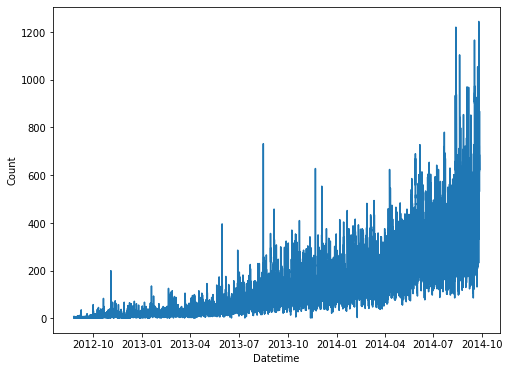

In [ ]:
plt.figure(figsize=(8,6))
sns.lineplot(x=train_df['Datetime'], y=train_df['Count'])
plt.show()

In [ ]:
#extract more features for visualization
train_df['year'] = train_df['Datetime'].dt.year
train_df['month'] = train_df['Datetime'].dt.month
train_df['week'] = train_df['Datetime'].dt.weekofyear

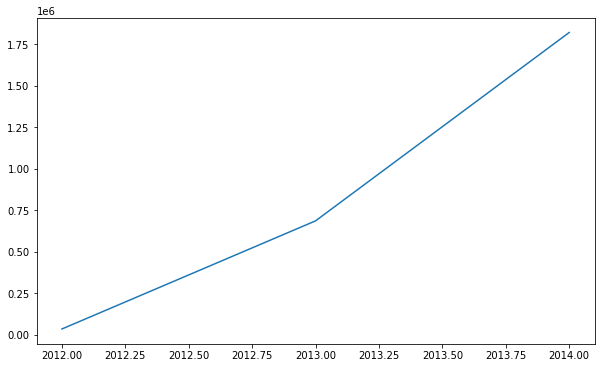

In [ ]:
#visualize count of passengers year-wise
plt.figure(figsize=(10,6))
count_by_year = train_df[['year', 'Count']].groupby(by=['year']).sum()
plt.plot(count_by_year)

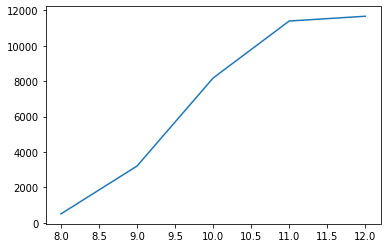

In [ ]:
#visualize passengers count month-wise for each year
count_by_month_2012 = train_df[train_df['year'] == 2012][['month', 'Count']].groupby(by=['month']).sum()
plt.plot(count_by_month_2012)

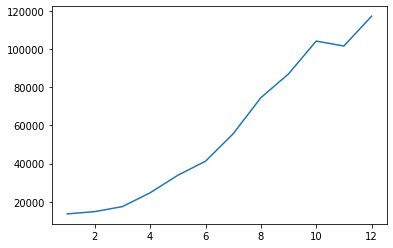

In [ ]:
count_by_month_2013 = train_df[train_df['year'] == 2013][['month', 'Count']].groupby(by=['month']).sum()
plt.plot(count_by_month_2013)

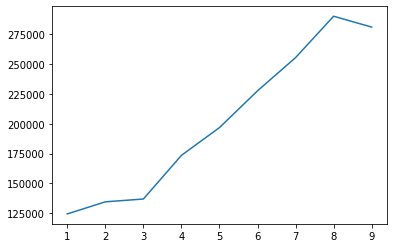

In [ ]:
count_by_month_2014 = train_df[train_df['year'] == 2014][['month', 'Count']].groupby(by=['month']).sum()
plt.plot(count_by_month_2014)

**From plots above, there is a coninous increasing trend in passangers**

In [ ]:
X = train_df['Count']
y = train_df['Count'].shift(-out_lag)

In [ ]:
cols, names = list(), list(['Count'])
for i in range(1, 31, 1):
  cols.append(X.shift(i))
  names.append("Count-{}".format(i))

features = pd.concat(cols, axis=1)
X_features = pd.concat([X, features], axis=1)
X_features.columns = names
X_features.fillna(0, inplace=True)

In [ ]:
X_features = X

**Modelling**

In [ ]:
X_test = X_features[-5112:]
X_features = X_features[:-5112]
y = y[:-5112]

split_index = int(len(X_features)*0.80)
X_train, y_train = X_features[0:split_index], y[0:split_index]
X_val, y_val = X_features[split_index:] , y[split_index:]

**Neural network**

In [ ]:
class IterStats(tf.keras.callbacks.Callback):
  lr = []
  train_loss = []
  val_loss = []
  iters = []
  def on_epoch_end(self, epoch, logs):
    self.lr.append(self.model.optimizer.learning_rate.numpy())
    self.train_loss.append(logs['loss'])
    self.val_loss.append(logs['val_loss'])
    self.iters.append(epoch)
    print ("lr: {} train_loss: {} val_loss: {} epoch: {}".format(self.model.optimizer.learning_rate.numpy(), logs['loss'], logs['val_loss'], epoch))


In [ ]:
stats = IterStats()

In [ ]:
def validate_model(model, train_x, train_y, val_x, val_y):
  opt = tf.keras.optimizers.Adam(lr=1e-4)
  #lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
  
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, mode='min')
  model.compile(loss='mse', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError()])
  model.fit(train_x, train_y, epochs=100, validation_data = (val_x, val_y), callbacks=[early_stopping, stats])

  return model

In [ ]:
def build_model(model, train_x, train_y, lr, iter):
  opt = tf.keras.optimizers.Adam(lr)
  model.compile(loss='mse', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError()])
  model.fit(train_x, train_y, epochs=iter)

  return model

**LSTM model**

In [ ]:
X_train = np.array(X_train).reshape(-1,1)
X_val = np.array(X_val).reshape(-1,1)

In [ ]:
#Reshaping the data as per expected dimension of LSTM
X_train = np.expand_dims(X_train[:,:], axis=2)
X_val = np.expand_dims(X_val[:,:], axis=2)

In [ ]:
X_val.shape

(2636, 1, 1)

In [ ]:
model = tf.keras.models.Sequential(
        [
          tf.keras.layers.LSTM(units=64, activation='relu',input_shape=(X_train.shape[1], X_train.shape[2])),
          tf.keras.layers.Dropout(0.2),          
          tf.keras.layers.Dense(1)
        ]
        )

model = validate_model(model,X_train, y_train, X_val, y_val)

Epoch 1/100
330/330 [==============================] - 3s 4ms/step - loss: 31585.4143 - root_mean_squared_error: 177.6953 - val_loss: 167173.1094 - val_root_mean_squared_error: 408.8681
lr: 9.999999747378752e-05 train_loss: 30742.708984375 val_loss: 167173.109375 epoch: 0
Epoch 2/100
330/330 [==============================] - 1s 3ms/step - loss: 27827.2158 - root_mean_squared_error: 166.7872 - val_loss: 102878.1406 - val_root_mean_squared_error: 320.7462
lr: 9.999999747378752e-05 train_loss: 26018.728515625 val_loss: 102878.140625 epoch: 1
Epoch 3/100
330/330 [==============================] - 1s 3ms/step - loss: 18747.3150 - root_mean_squared_error: 136.8619 - val_loss: 71038.1094 - val_root_mean_squared_error: 266.5298
lr: 9.999999747378752e-05 train_loss: 17373.80078125 val_loss: 71038.109375 epoch: 2
Epoch 4/100
330/330 [==============================] - 1s 3ms/step - loss: 15022.3832 - root_mean_squared_error: 122.5456 - val_loss: 57562.9258 - val_root_mean_squared_error: 239.9227

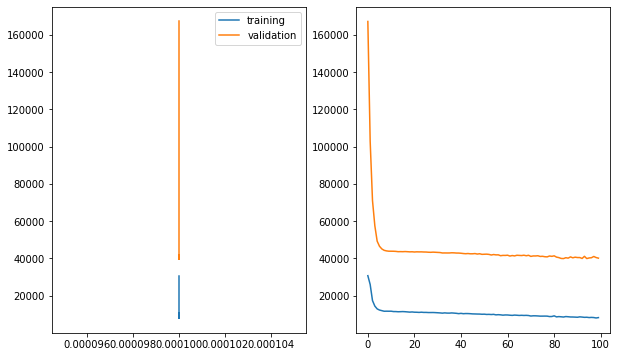

In [ ]:
#plot the epochs and learning rate against train and validation loss
fig, ax = plt.subplots(1,2,figsize=(10,6))

plt.subplot(1,2,1)
plt.plot(stats.lr, stats.train_loss, label='training')
plt.plot(stats.lr, stats.val_loss, label='validation')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.plot(stats.iters, stats.train_loss, label='training')
plt.plot(stats.iters, stats.val_loss, label='validation')


In [ ]:
X_features = np.array(X_features).reshape(-1,1)
X_features = np.expand_dims(X_features[:,:], axis=2)

In [ ]:
X_features.shape

(13176, 1, 1)

In [ ]:
#train the model based on plots above
#X_features = np.expand_dims(X_features.values[:,:], axis=2)
lr = 1e-4
epochs=50
final_model = build_model(model, X_features, y, lr, epochs)

Epoch 1/50
412/412 [==============================] - 2s 2ms/step - loss: 15762.4401 - root_mean_squared_error: 125.5245
Epoch 2/50
412/412 [==============================] - 1s 2ms/step - loss: 14618.6915 - root_mean_squared_error: 120.8705
Epoch 3/50
412/412 [==============================] - 1s 2ms/step - loss: 14784.6586 - root_mean_squared_error: 121.5451
Epoch 4/50
412/412 [==============================] - 1s 2ms/step - loss: 15051.0700 - root_mean_squared_error: 122.6218
Epoch 5/50
412/412 [==============================] - 1s 2ms/step - loss: 14749.6846 - root_mean_squared_error: 121.4192
Epoch 6/50
412/412 [==============================] - 1s 2ms/step - loss: 14684.7050 - root_mean_squared_error: 121.1331
Epoch 7/50
412/412 [==============================] - 1s 2ms/step - loss: 15065.9193 - root_mean_squared_error: 122.6849
Epoch 8/50
412/412 [==============================] - 1s 2ms/step - loss: 15158.1292 - root_mean_squared_error: 123.0663
Epoch 9/50
412/412 [============

In [ ]:
X_test = np.array(X_test).reshape(-1,1)
X_test = np.expand_dims(X_test[:,:], axis=2)

In [ ]:
test_predictions = final_model.predict(X_test)
y_test = test_predictions.reshape(-1,)

**Test submission**

In [ ]:
test_predictions = pd.DataFrame({'ID':test_df['ID'], 'Count':y_test})
test_predictions.to_csv('./submission.csv', index=False)